# Learning Functional ANOVA Decompositions in FAVA: Continuous Responses

In this tutorial, we show how to solve penalized least squares problems of the form

$$\hat{f} = \arg \min_{f \in H} \sum_{n=1}^N (y^{(n)} - f(x^{(n)}))^2 + \lambda \|f\|_{\mathcal{H}}^2, $$

where $\mathcal{H}$ consists of the space of interactions of order up to $Q$: 

$$\mathcal{H} = \left\{f: f = \sum_{V: |V| \leq Q} f_V \right\} \quad \text{s.t.} \quad \forall A \subsetneq B, \ f_A \perp_{\mathcal{H}} f_B.$$

# Import packages

We start by importing the required packages in `fava` and `jax`.

In [41]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

from fava.inference.fit import GaussianSKIMFA
from fava.basis.maps import LinearBasis
from fava.misc.scheduler import truncScheduler, constantScheduler
from fava.misc.logger import GausLogger
from fava.decomposers.decomposer import all_subsets
from fava.decomposers.tensor_product import TensorProductKernelANOVA, LinearANOVA
from fava.plots.waterfall import anova_waterfall

# Simulating data

Below we generate simulated data, where the covariates $x \in \mathbb{R}^{100}$ and $y \in \mathbb{R}$. We assume that the first 4 covariates drive the response $y$, and the remaining covariates have no influence on the response. Specifically, the $n$th datapoint is generated as follows: $y^{(n)} = x_1^{(n)}x_2^{(n)} + x_2^{(n)}x_3^{(n)} + \epsilon^{(n)}$, where $\epsilon^{(n)} \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, 1)$ for $1 \leq n \leq 500$.


In [2]:
key = random.PRNGKey(0) # set seed
N = 500
p = 100
X = random.normal(key, shape=(N, p))
epsilon = random.normal(key, shape=(N, ))
Y = X[:, 0] + X[:, 1] + X[:, 2] * X[:, 3] + epsilon

# Split data into training and validation

In [3]:
# Use 80% of the data for training and 20% for validation
X_train = X[:400, :]
Y_train = Y[:400]

X_valid = X[400:, :]
Y_valid = Y[400:]

# Fit SKIM-FA Model

Below we initialize SKIM-FA hyperparameters with default values. We run a total of $T=500$ iterations. The parameters that maximize predictive performance on the validation set are selected.

In [4]:
kernel_params = dict()
Q = 2
kernel_params['U_tilde'] = jnp.ones(p)
kernel_params['eta'] = jnp.ones(Q+1)

hyperparams = dict()
hyperparams['sigma_sq'] = .5 * jnp.var(Y)
hyperparams['c'] = .2

opt_params = dict()
opt_params['cg'] = True
opt_params['cg_tol'] = .01
opt_params['M'] = 100
opt_params['gamma'] = .1
opt_params['T'] = 500
opt_params['scheduler'] = constantScheduler() # we won't get exact sparsity since c is constant
featprocessor = LinearBasis(X_train)
logger = GausLogger(100)

skim = GaussianSKIMFA(X_train, Y_train, X_valid, Y_valid, featprocessor)

skim.fit(key, hyperparams, kernel_params, opt_params, 
            logger=GausLogger())

  0%|                                                                                                                 | 0/500 [00:00<?, ?it/s]

============================== Iteration 0/500 ==============================
There are 100 covariates selected.


  0%|▏                                                                                                        | 1/500 [00:04<34:16,  4.12s/it]

MSE (Validation)=2.5803.
R2 (Validation)=0.4308.
eta=[1.0000176  1.0927966  0.90706474]
c=0.2
kappa=[0.427512   0.43775743 0.38954645 0.3935901  0.37155294 0.37196064
 0.37526184 0.37408942 0.37568456 0.37432647 0.36845684 0.3702034
 0.37719196 0.38341844 0.37717736 0.36670595 0.3718865  0.37691826
 0.373253   0.37422097 0.36725998 0.37259445 0.37028933 0.3774687
 0.3699179  0.37486166 0.36752617 0.37550277 0.37107378 0.37370145
 0.37118727 0.37558192 0.3727138  0.37480414 0.3790542  0.36897695
 0.36873615 0.37040257 0.3758871  0.3640982  0.37777245 0.37394568
 0.3741271  0.37913078 0.36967307 0.37678212 0.36617234 0.37765032
 0.37358582 0.37470585 0.37127936 0.3739831  0.37635857 0.37284583
 0.37119448 0.36952233 0.37866533 0.37040457 0.36523217 0.37135786
 0.37115157 0.37187934 0.37034845 0.38416728 0.37458822 0.3745625
 0.3640228  0.36721563 0.37601233 0.36932468 0.37321633 0.37741148
 0.37234172 0.36836708 0.38273335 0.36760545 0.3676412  0.37340626
 0.370626   0.368869   0.3669037

 20%|████████████████████▌                                                                                  | 100/500 [00:40<02:29,  2.68it/s]

============================== Iteration 100/500 ==============================
There are 100 covariates selected.


 20%|████████████████████▊                                                                                  | 101/500 [00:41<03:06,  2.14it/s]

MSE (Validation)=1.3841.
R2 (Validation)=0.6947.
eta=[0.9999887 1.3747737 0.9144955]
c=0.2
kappa=[6.00533366e-01 7.12121010e-01 7.55946636e-01 7.38661885e-01
 9.70444232e-02 1.35944620e-01 3.23872805e-01 2.21708059e-01
 3.68328750e-01 1.52646989e-01 4.55686823e-03 3.95288505e-02
 4.23630416e-01 5.94578862e-01 3.95420492e-01 6.48644418e-02
 3.55876796e-02 1.52589217e-01 4.42870110e-01 4.45499718e-01
 2.59182364e-01 5.53305745e-01 8.97421539e-02 2.11845845e-01
 2.62815878e-02 4.27186430e-01 5.54319471e-03 2.59970367e-01
 1.76841207e-02 1.55978113e-01 4.25242484e-01 4.36426997e-01
 3.58408153e-01 1.50096774e-01 3.96640152e-01 2.06939876e-05
 3.92727703e-01 3.60691920e-03 2.81037182e-01 1.52833253e-01
 3.35450828e-01 2.36021146e-01 1.11472666e-01 3.18701208e-01
 2.60427780e-02 2.70474792e-01 8.47736895e-02 3.92875522e-01
 8.51355493e-03 1.57945171e-01 1.39246792e-01 1.13734692e-01
 5.08838892e-01 1.80299148e-01 1.88473001e-01 2.56500602e-01
 4.53495234e-01 2.87338287e-01 8.59403461e-02 4.6

 40%|█████████████████████████████████████████▏                                                             | 200/500 [01:20<01:59,  2.51it/s]

============================== Iteration 200/500 ==============================
There are 100 covariates selected.


 40%|█████████████████████████████████████████▍                                                             | 201/500 [01:21<02:27,  2.03it/s]

MSE (Validation)=1.4887.
R2 (Validation)=0.6716.
eta=[1.0004566 1.4380944 1.1376388]
c=0.2
kappa=[6.2743258e-01 7.3651725e-01 7.6308870e-01 7.0940852e-01 2.0461157e-04
 2.0501800e-02 3.8944775e-01 2.5866377e-01 3.5027817e-01 4.6840478e-02
 8.1397593e-06 6.8195723e-03 4.4969484e-01 5.5788112e-01 3.0442882e-01
 1.0646433e-02 2.9263832e-03 7.8737274e-02 4.5009410e-01 4.8115796e-01
 2.0670661e-01 5.5233389e-01 2.6717037e-02 8.9344814e-02 2.5185198e-03
 3.0607802e-01 4.8698857e-04 2.2730099e-01 7.1413815e-05 6.4214483e-02
 4.9844211e-01 4.2579836e-01 2.0739073e-01 1.9914284e-03 4.6285287e-01
 1.3038516e-07 2.8915259e-01 1.7266721e-05 3.9117169e-02 1.3263480e-01
 2.9512042e-01 6.5138876e-02 2.3706630e-03 4.6266958e-01 3.5207979e-02
 1.7639430e-01 4.1069649e-03 2.7074286e-01 4.2468309e-06 2.5516275e-01
 2.4424829e-02 7.5013004e-03 5.7430041e-01 4.4024363e-02 9.8584011e-02
 2.7162430e-01 3.2604659e-01 3.6310479e-01 7.0391804e-02 5.6765521e-01
 3.7037349e-01 2.0366162e-04 2.2267178e-03 5.683970

 60%|█████████████████████████████████████████████████████████████▊                                         | 300/500 [02:01<01:19,  2.53it/s]

============================== Iteration 300/500 ==============================
There are 100 covariates selected.


 60%|██████████████████████████████████████████████████████████████                                         | 301/500 [02:01<01:35,  2.08it/s]

MSE (Validation)=1.7322.
R2 (Validation)=0.6179.
eta=[1.0039895 1.5636828 1.2282599]
c=0.2
kappa=[6.3940847e-01 7.4913049e-01 7.7015197e-01 6.7330444e-01 1.8626451e-07
 5.0112605e-04 4.1887507e-01 2.9173839e-01 3.4908116e-01 3.7279166e-03
 2.4214387e-07 2.2080541e-03 4.4450492e-01 4.8493519e-01 2.5791678e-01
 4.0283613e-03 2.0150840e-03 7.1995497e-02 4.7270104e-01 4.6363986e-01
 1.7665735e-01 5.8669060e-01 1.9527208e-02 9.1481768e-03 9.0152025e-05
 2.7457690e-01 3.6861748e-05 1.3927491e-01 3.7252903e-07 2.6763678e-02
 4.4786930e-01 4.6910191e-01 4.9205441e-02 4.1890889e-05 5.0622529e-01
 1.3038516e-07 2.7400467e-01 5.7742000e-07 8.0591068e-04 9.2223972e-02
 2.5340298e-01 5.8053918e-02 9.4994903e-07 5.1016295e-01 1.2796806e-01
 2.2584102e-01 8.0037862e-05 1.6265625e-01 4.6566129e-07 3.2618350e-01
 9.0770423e-04 1.7171912e-03 5.6533980e-01 4.3935888e-03 1.2710476e-01
 2.2468126e-01 1.5852162e-01 3.3922529e-01 6.3246801e-02 5.9934443e-01
 2.9516441e-01 4.8987567e-06 9.4063580e-06 5.268405

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 400/500 [02:39<00:37,  2.66it/s]

============================== Iteration 400/500 ==============================
There are 100 covariates selected.


 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 401/500 [02:40<00:45,  2.18it/s]

MSE (Validation)=2.0149.
R2 (Validation)=0.5555.
eta=[1.0111151 1.7499819 1.2703197]
c=0.2
kappa=[6.22618318e-01 7.54343927e-01 7.78473616e-01 6.33080244e-01
 1.86264515e-07 6.03497028e-06 4.04189974e-01 2.88623840e-01
 3.21125239e-01 4.21404839e-04 1.86264515e-07 6.22030348e-04
 3.95276695e-01 4.42406893e-01 2.69092739e-01 6.92164525e-03
 1.74995512e-04 1.04006886e-01 4.86630559e-01 4.17416453e-01
 1.41881615e-01 6.26288295e-01 4.47485596e-02 1.83656812e-05
 2.08616257e-06 2.63900399e-01 1.76951289e-06 7.54447430e-02
 2.79396772e-07 4.61198390e-03 3.65673751e-01 5.37077904e-01
 6.86571002e-05 1.13621354e-06 5.06975651e-01 1.30385160e-07
 2.02107593e-01 5.02914190e-07 4.28408384e-07 6.92631453e-02
 2.42169261e-01 7.87873417e-02 2.79396772e-07 5.38698971e-01
 1.78796187e-01 2.92907298e-01 1.26659870e-06 1.05669707e-01
 4.65661287e-07 3.32516283e-01 5.53578138e-05 9.00216401e-05
 5.41176915e-01 1.74921006e-04 1.26398489e-01 1.97207689e-01
 1.07161835e-01 2.84592241e-01 4.48504463e-03 6.1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:18<00:00,  2.52it/s]


# Compare predictive performance against random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

In [6]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0)
rf.fit(np.array(X), np.array(Y))

RandomForestRegressor(n_estimators=1000, random_state=0)

In [7]:
# Generate new test set and compare R^2 performance
N_test = 1000
X_test = random.normal(key, shape=(N_test, p))
epsilon = random.normal(key, shape=(N_test, ))
Y_test = X_test[:, 0] + X_test[:, 1] + X_test[:, 2] * X_test[:, 3] + epsilon

In [8]:
rf_r2 = rf.score(np.array(X_test), np.array(Y_test))
skimfa_r2 = r2_score(Y_test, skim.predict(X_test))

In [9]:
print(f'Random Forest Test R^2: {round(rf_r2, 4)}')
print(f'SKIM-FA Test R^2: {round(skimfa_r2, 4)}')

Random Forest Test R^2: 0.4495
SKIM-FA Test R^2: 0.6038


# Report effects

Now we compute all of the main/interaction effects found by SKIM-FA. Since we fit a linear interaction model, we report the regression coefficients associated with each effect. Since we used a constant scheduler for c, we do not get exact sparsity.

In [10]:
# Compute all main and in
lanova = LinearANOVA(skim)
V_all = all_subsets(skim.selected_covariates(), 2, True)
all_skim_effects = dict()
for V in V_all:
    all_skim_effects[V] = lanova.get_coef(V)

In [11]:
# Report Top 5 positive effects found
top5_positive = sorted(all_skim_effects, key=all_skim_effects.get, reverse=True)[:5]
top5_negative = sorted(all_skim_effects, key=all_skim_effects.get, reverse=False)[:5]

print('Top 5 Strongest Positive Effects Found:')
for V in top5_positive:
    print(V,  round(all_skim_effects[V], 3))

Top 5 Strongest Positive Effects Found:
(1,) 0.923
(0,) 0.861
(2, 3) 0.739
(65,) 0.109
(30,) 0.105


In [12]:
print('Top 5 Strongest Negative Effects Found:')
for V in top5_negative:
    print(V,  round(all_skim_effects[V], 3))

Top 5 Strongest Negative Effects Found:
(2,) -0.107
(52,) -0.091
(2, 21) -0.089
(83,) -0.088
(70,) -0.086


In [13]:
Y_test_pred = skim.predict(X_test)
variation_intercept = lanova.get_variation_at_order(X_test, 0)
variation_additive = lanova.get_variation_at_order(X_test, 1)
variation_pairwise = lanova.get_variation_at_order(X_test, 2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:29<00:00, 170.18it/s]


# Global importance of each feature (i.e., the "sobol index")

In [14]:
# The sum of the variation at each order recovers the prediction output
check = variation_intercept + variation_additive + variation_pairwise
assert jnp.abs(Y_test_pred - check).max() < 1e-5

In [17]:
decomposition = lanova.get_decomposition(X_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5051/5051 [00:28<00:00, 179.21it/s]


In [25]:
covariate_variation = dict()
for cov_ix in lanova.selected_covs:
    covariate_variation[cov_ix] = lanova.get_variation_at_covariate(X_train, cov_ix).var().item()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 164.65it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.67it/s]


In [ ]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True))

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [108]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
import pandas as pd
from fava.plots.colors import red_rgb, blue_rgb

sns.set_style('whitegrid')

def make_name(cov_ix):
    return f'Feature {cov_ix}'
    

max_feats = 10
sobol_index_df = pd.DataFrame(list(covariate_variation.items()))
sobol_index_df.columns = ['cov_ix', 'variance']
sobol_index_df['names'] = sobol_index_df['cov_ix'].apply(make_name)
sobol_index_df = sobol_index_df.sort_values(by='variance', ascending=False)
sobol_index_df['norm_variance'] = 100 * sobol_index_df['variance'].values / sobol_index_df['variance'].sum()

if sobol_index_df.shape[0] > max_feats:
    top_feats = sobol_index_df.head(max_feats)
    n_removed_feats = sobol_index_df.shape[0] - max_feats
    remaining_feats = sobol_index_df.tail(n_removed_feats)
    remaining_variance = remaining_feats['norm_variance'].sum()
    remain_df = pd.DataFrame({'names': [f'{n_removed_feats} other features'], 'norm_variance': [remaining_variance]})
    top_feats = pd.concat([top_feats, remain_df])
            


In [109]:
top_feats

,cov_ix,variance,names,norm_variance
1,1.0,0.981458,Feature 1,25.814686
0,0.0,0.783941,Feature 0,20.619503
2,2.0,0.649049,Feature 2,17.071520
3,3.0,0.631188,Feature 3,16.601743
91,91.0,0.052107,Feature 91,1.370530
21,21.0,0.051725,Feature 21,1.360485
13,13.0,0.046986,Feature 13,1.235838
65,65.0,0.041635,Feature 65,1.095098
63,63.0,0.036420,Feature 63,0.957929
52,52.0,0.029750,Feature 52,0.782499


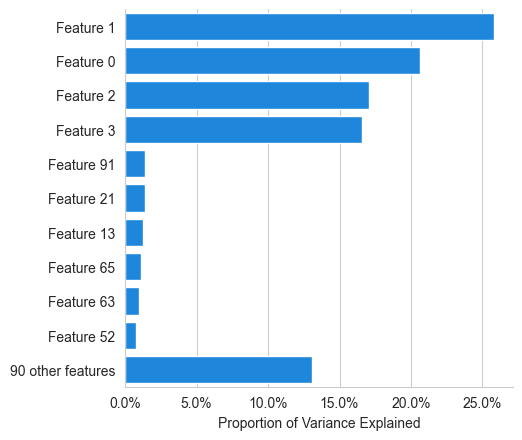

In [110]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
sns.barplot(x='norm_variance', y='names', data=top_feats, color=blue_rgb)
plt.xlabel('Proportion of Variance Explained')
plt.ylabel('')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine()

# Plot an explanation of a single prediction as a waterfall plot

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5051/5051 [00:28<00:00, 177.27it/s]


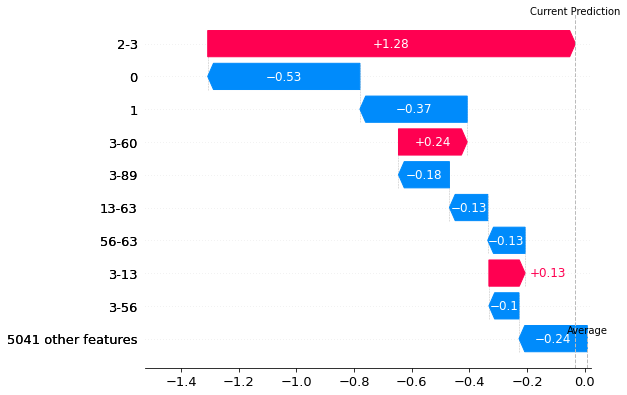

In [16]:
# Prediction attribution breakdown for first test datapoint
anova_waterfall(X_test[0,:], lanova, [str(i) for i in range(p)])